<a href="https://colab.research.google.com/github/muhamad-kurniawan/deep_learning_course_CNU/blob/main/Exercise_3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edited from https://github.com/nhduong/intro_deep/blob/master/examples/2.%20CNN%20%2B%20MLP/3_Emotion_Reg_CNN.ipynb

# Overview
- FER2013 dataset (face images + facial expression)
  + Goal: classifying facial exprression
  + Input: a 48x48 image
  + Output: facial expression (angry, disgust, fear, happy, neutral, sad, and surprise)
- Defining an CNN+MLP
- Training and evaluating an CNN+MLP

# Import libraries

In [ ]:
# !pip install pydot
# !pip install graphviz
# !pip install --upgrade keras
# !pip install tensorflow==2.15.0 --user
# !pip install protobuf==3.12.4 --user
# !pip install --upgrade tensorflow

In [ ]:
# !pip install tensorflow[and-cuda] --user

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import keras
from keras import layers
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, BatchNormalization
from keras.optimizers import Adam

from IPython.display import SVG
from keras.utils import model_to_dot

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

2


In [ ]:
num_classes = 7   # angry, disgust, fear, happy, neutral, sad, and surprise

# (1) Data

### Download data at https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/

In [ ]:
dataset = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')
train_data = dataset[dataset[' Usage']=='Training']
test_public_data = dataset[dataset[' Usage']=='PublicTest']
test_private_data = dataset[dataset[' Usage']=='PrivateTest']

dataset

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [ ]:
x_train = np.array([list(map(int, x.split())) for x in train_data[' pixels']])
y_train = keras.utils.to_categorical(train_data['emotion'])

x_test_public = np.array([list(map(int, x.split())) for x in test_public_data[' pixels']])
y_test_public = keras.utils.to_categorical(test_public_data['emotion'])

x_test_private = np.array([list(map(int, x.split())) for x in test_private_data[' pixels']])
y_test_private = keras.utils.to_categorical(test_private_data['emotion'])

x_train = x_train.reshape(x_train.shape[0], 48, 48)
# x_train = np.expand_dims(x_train, axis=4)

x_test_public = x_test_public.reshape(x_test_public.shape[0], 48, 48)
# x_test_public = np.expand_dims(x_test_public, axis=4)

x_test_private = x_test_private.reshape(x_test_private.shape[0], 48, 48)
# x_test_private = np.expand_dims(x_test_private, axis=4)

In [ ]:
x_train.shape

(28709, 48, 48)

In [ ]:
x_train[0]

array([[ 70,  80,  82, ...,  52,  43,  41],
       [ 65,  61,  58, ...,  56,  52,  44],
       [ 50,  43,  54, ...,  49,  56,  47],
       ...,
       [ 91,  65,  42, ...,  72,  56,  43],
       [ 77,  82,  79, ..., 105,  70,  46],
       [ 77,  72,  84, ..., 106, 109,  82]])

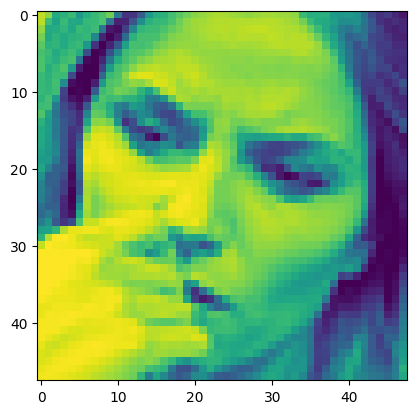

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[2])

# (2) Declare model

In [ ]:
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
input_image = Input(shape=(48, 48, 1), name='Input')

# conv, pooling layers + dropout
x = Rescaling(1/255)(input_image)
x = layers.RandomFlip("horizontal")(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.25, name='conv_dropout1')(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv3')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv4')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv5')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.25, name='conv_dropout2')(x)

x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv6')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv7')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv8')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv9')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
x = Dropout(rate=0.25, name='conv_dropout3')(x)

# similar to the MLP example!
# matrix ---> vector
x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5, name='fc_dropout1')(x)
x = Dense(units=1024, activation='relu', name='fc2')(x)
x = Dropout(rate=0.5, name='fc_dropout2')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_7ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='emo_cnn')

# print model summary
model.summary()

Model: "emo_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_6 (RandomFlip)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dropout1 (Dropout)         │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dropout2 (Dropout)         │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv8 (Conv2D)                  │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv9 (Conv2D)                  │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dropout3 (Dropout)         │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_dropout1 (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 1024)           │     1,049,60

 Total params: 12,967,495 (49.47 MB)

 Trainable params: 12,967,239 (49.47 MB)

 Non-trainable params: 256 (1.00 KB)

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [ ]:

# declare learning rate, loss function, and model metric
loss = 'categorical_crossentropy'
lr = 0.0001
model.compile(loss=loss, optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

# train the model
batch_size = 128
epochs = 30

starting_time = time.time()
history = model.fit(x_train, y_train,
                    validation_data=(x_test_public, y_test_public),
                    batch_size=batch_size,
                    epochs=epochs)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/30
  2/225 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.1602 - loss: 2.0147

W0000 00:00:1713170628.244777    4766 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.2334 - loss: 1.8299

W0000 00:00:1713170655.564877    4765 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713170657.155213    4765 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 134ms/step - accuracy: 0.2335 - loss: 1.8297 - val_accuracy: 0.2639 - val_loss: 1.8484
Epoch 2/30
  2/225 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.3125 - loss: 1.7201

W0000 00:00:1713170658.322336    4767 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.3597 - loss: 1.6356 - val_accuracy: 0.4096 - val_loss: 1.6528
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.4399 - loss: 1.4428 - val_accuracy: 0.4876 - val_loss: 1.3316
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.4863 - loss: 1.3260 - val_accuracy: 0.5233 - val_loss: 1.2235
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5209 - loss: 1.2564 - val_accuracy: 0.5430 - val_loss: 1.1795
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5419 - loss: 1.1977 - val_accuracy: 0.5587 - val_loss: 1.1503
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5583 - loss: 1.1500 - val_accuracy: 0.5731 - val_loss: 1.1302
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5727 - loss: 1.1118 - val_accuracy: 0.5848 - val_loss: 1.0998
Epoch 9/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5838 - loss: 1.0864 - val_accurac

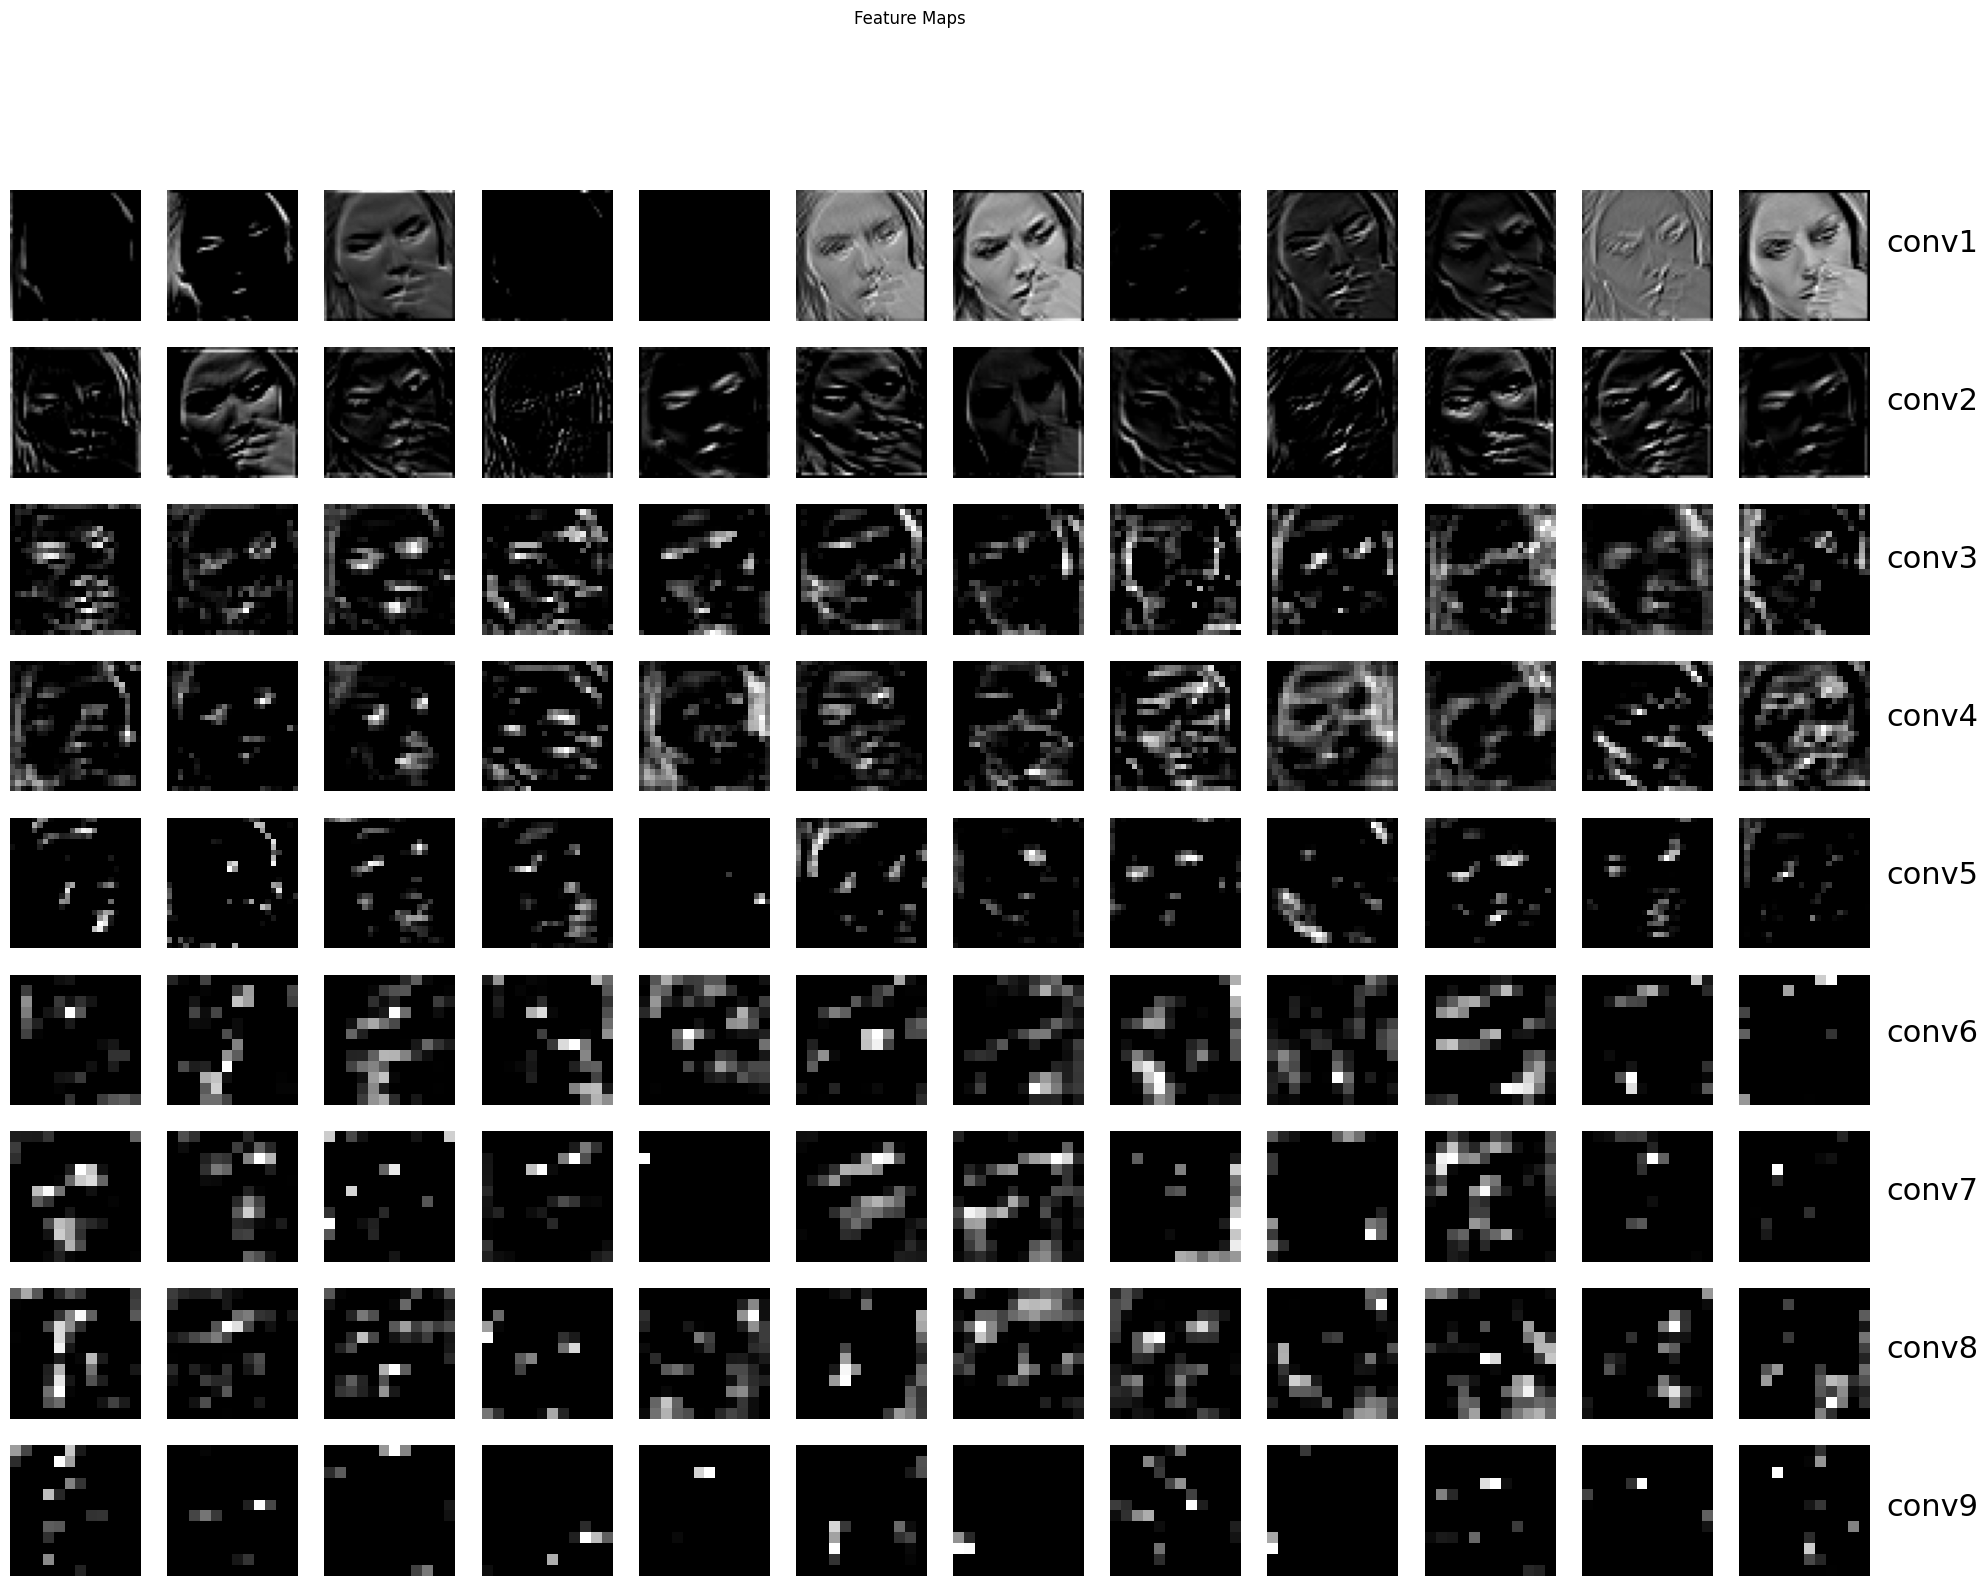

In [ ]:
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

def show_feature_maps(model, input_array, layer_names):
    x = np.expand_dims(input_array, axis=0)

    layer_outputs = [model.get_layer(name).output for name in layer_names]
    layer_outputs = Model(inputs=model.input, outputs=layer_outputs)(x)

    #show first 12 filter for each conv layer
    fig, axes = plt.subplots(len(layer_names), 12, figsize=(24, 2 * len(layer_names)))
    for i, layer_output in enumerate(layer_outputs):
        num_filters = layer_output.shape[-1]
        for j in range(min(12, num_filters)):
            ax = axes[i, j]
            ax.imshow(layer_output[0, :, :, j], cmap='gray')
            ax.axis('off')
        axes[i, 0].set_ylabel(layer_names[i])

    plt.suptitle("Feature Maps")
    #add label
    coor_y = -110
    for n in range(9):
        plt.text(13, coor_y, f'conv{n+1}', fontsize = 22)
        coor_y+=14.5
    plt.show()

# Input image/array
input_array = x_train[2]

# Visualize feature maps for specific layers
layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9']
show_feature_maps(model, input_array, layer_names)

# (4) Evaluate trained model

In [ ]:
score = model.evaluate(x_test_private, y_test_private)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

 16/113 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6687 - loss: 1.0193 

W0000 00:00:1713171187.601678    4764 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6637 - loss: 1.0048
Test loss: 1.0223184823989868
Test accuracy: 0.6636946201324463


In [ ]:
def get_emotion(ohv):
    indx = np.argmax(ohv)

    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


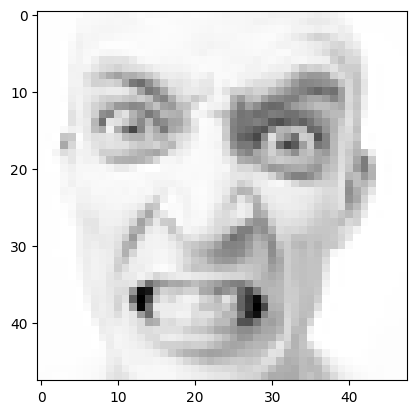

> testing image index: 2291
> true emotion: angry
> predicted emotion: angry


In [ ]:
# 2163
img_indx = np.uint32(np.random.rand()*(x_test_private.shape[0] - 1))
sample = x_test_private[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_test_private[img_indx, :]), get_emotion(pred_cls)))